In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve
)

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")


In [18]:

df = pd.read_csv('../data/customer_features.csv')

print(f"Data loaded: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Churn rate: {df['Churn'].mean():.2%}")

Data loaded: 5,630 rows x 16 columns
Churn rate: 16.84%


In [19]:
# 변수 선택
feature_cols = [
    'Tenure',
    'OrderCount',
    'DaySinceLastOrder',
    'SatisfactionScore',
    'CashbackAmount',
    'Complain',
    'NumberOfDeviceRegistered',
    'CityTier',
    
    'is_new',
    'is_inactive',
    'low_orders',
    'dissatisfied',
    'has_complaint',
    'no_cashback'
]

X = df[feature_cols]
y = df['Churn']

print(f"Features selected: {len(feature_cols)}")
print(f"Feature names: {feature_cols}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"Churn rate: {y.mean():.2%}")

Features selected: 14
Feature names: ['Tenure', 'OrderCount', 'DaySinceLastOrder', 'SatisfactionScore', 'CashbackAmount', 'Complain', 'NumberOfDeviceRegistered', 'CityTier', 'is_new', 'is_inactive', 'low_orders', 'dissatisfied', 'has_complaint', 'no_cashback']

Target distribution:
Churn
0    4682
1     948
Name: count, dtype: int64
Churn rate: 16.84%


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Train set: {len(X_train):,} rows (Churn: {y_train.mean():.2%})")
print(f"Test set: {len(X_test):,} rows (Churn: {y_test.mean():.2%})")

Train set: 4,504 rows (Churn: 16.83%)
Test set: 1,126 rows (Churn: 16.87%)


### Logistic Regression 모델

In [4]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

auc_lr = roc_auc_score(y_test, y_proba_lr)

print("Logistic Regression Results:")
print(f"AUC-ROC: {auc_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Retained', 'Churned']))

Logistic Regression Results:
AUC-ROC: 0.8447

Classification Report:
              precision    recall  f1-score   support

    Retained       0.89      0.96      0.92       936
     Churned       0.68      0.41      0.51       190

    accuracy                           0.87      1126
   macro avg       0.79      0.69      0.72      1126
weighted avg       0.85      0.87      0.85      1126



Churned 클래스의 recall이 0.41로 낮음 (이탈 고객의 41%만 탐지)
Random Forest로 개선될 것으로 예상

### Random Forest 모델

In [21]:
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"\nAUC-ROC: {auc_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Retained', 'Churned']))


AUC-ROC: 0.9585

Classification Report:
              precision    recall  f1-score   support

    Retained       0.93      0.98      0.95       936
     Churned       0.86      0.63      0.73       190

    accuracy                           0.92      1126
   macro avg       0.90      0.80      0.84      1126
weighted avg       0.92      0.92      0.91      1126



AUC: 0.8447 → 0.9585 
Churned recall: 0.41 → 0.63 (이탈 탐지율 50% 향상)
Overall accuracy: 87% → 92%

### ROC Curve 비교

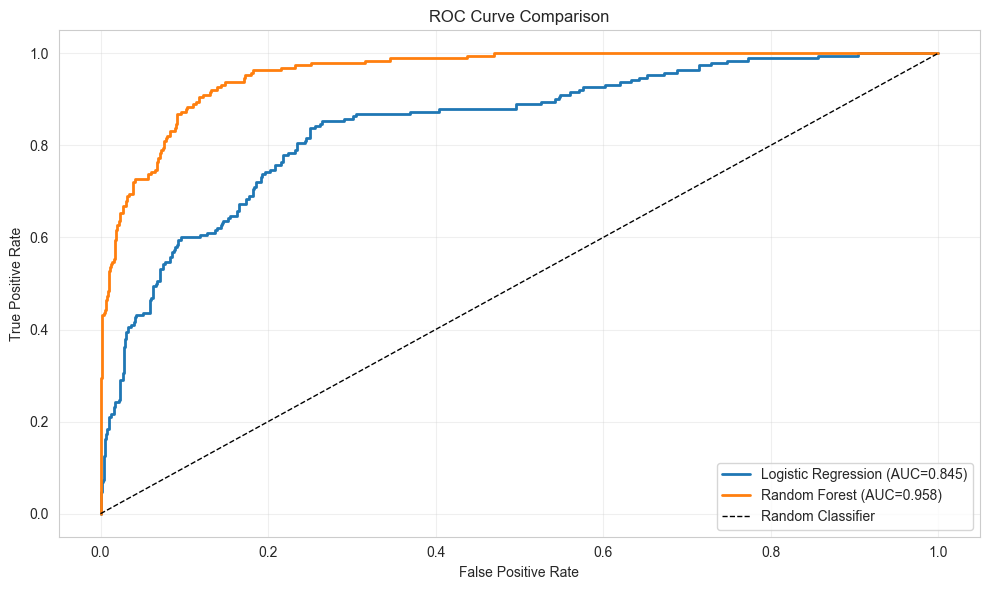

In [6]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

### Confusion Matrix

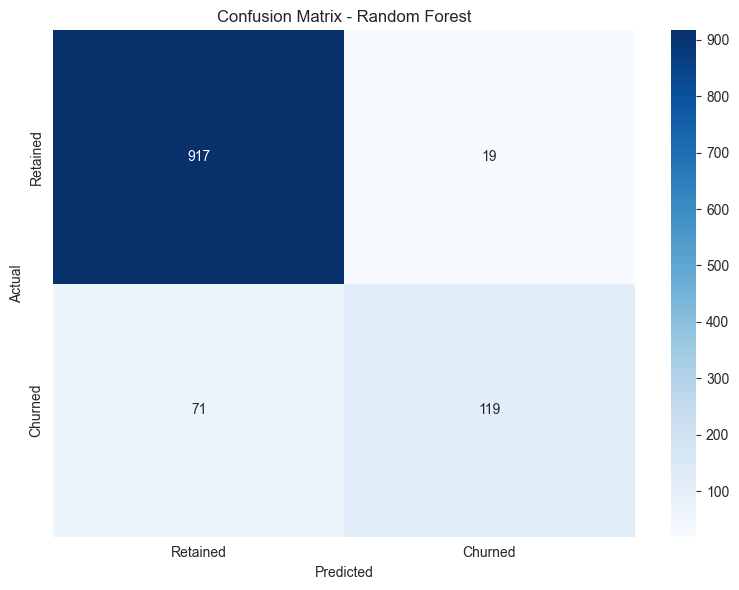

True Negatives (Correct Retained):  917
False Positives (Wrong Churn):      19
False Negatives (Missed Churn):     71
True Positives (Correct Churn):     119


In [15]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.savefig('../outputs/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Correct Retained):  {tn:,}")
print(f"False Positives (Wrong Churn):      {fp:,}")
print(f"False Negatives (Missed Churn):     {fn:,}")
print(f"True Positives (Correct Churn):     {tp:,}")

이탈고객 190명 중에서 119명을 탐지함 이는 63%이다
유지 고객을 이탈로 잘못 분류한 경우는 19명 뿐이다 

### Feature Importance

Feature Importance (Top 10):
                 Feature  Importance
                  Tenure    0.373095
          CashbackAmount    0.164884
       DaySinceLastOrder    0.099893
NumberOfDeviceRegistered    0.068367
              OrderCount    0.056012
           has_complaint    0.055665
       SatisfactionScore    0.055194
                Complain    0.048189
                CityTier    0.042261
            dissatisfied    0.021149


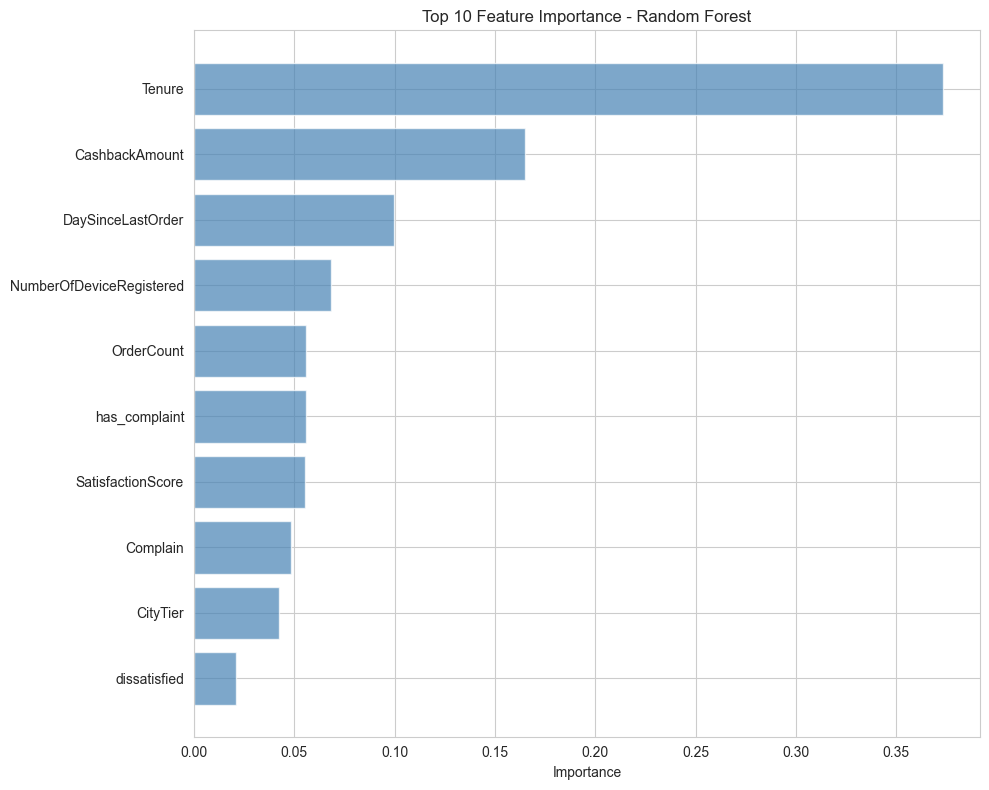

In [8]:
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Top 10):")
print(importance_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 8))
top_features = importance_df.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../outputs/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

Tenure가 압도적 1위를 차지했다 (37.3%) - 이용 기간이 가장 중요하다
플래그 변수 중에서는 has_complaint가 중요하다

### 고객 세그먼트 분류

In [23]:
# Test 세트에 예측 확률 추가
df_test_segment = X_test.copy()
df_test_segment['churn_probability'] = y_proba_rf
df_test_segment['actual_churn'] = y_test.values
df_test_segment['predicted_churn'] = y_pred_rf

# 위험도 그룹 생성
df_test_segment['risk_segment'] = pd.cut(
    df_test_segment['churn_probability'],
    bins=[0, 0.3, 0.7, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

segment_stats = df_test_segment.groupby('risk_segment').agg({
    'churn_probability': ['count', 'mean'],
    'actual_churn': 'sum'
}).round(3)

segment_stats.columns = ['Customer_Count', 'Avg_Churn_Prob', 'Actual_Churned']
segment_stats['Actual_Churn_Rate'] = (
    segment_stats['Actual_Churned'] / segment_stats['Customer_Count'] * 100
).round(2)

print("Customer Risk Segmentation:")
print(segment_stats)

Customer Risk Segmentation:
              Customer_Count  Avg_Churn_Prob  Actual_Churned  \
risk_segment                                                   
Low Risk                 896           0.062              35   
Medium Risk              152           0.480              80   
High Risk                 77           0.824              75   

              Actual_Churn_Rate  
risk_segment                     
Low Risk                   3.91  
Medium Risk               52.63  
High Risk                 97.40  


C:\Users\color\AppData\Local\Temp\ipykernel_2252\3923896525.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = df_test_segment.groupby('risk_segment').agg({


C:\Users\color\AppData\Local\Temp\ipykernel_2252\2060205127.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  actual_rates = df_test.groupby('risk_segment')['actual_churn'].mean() * 100


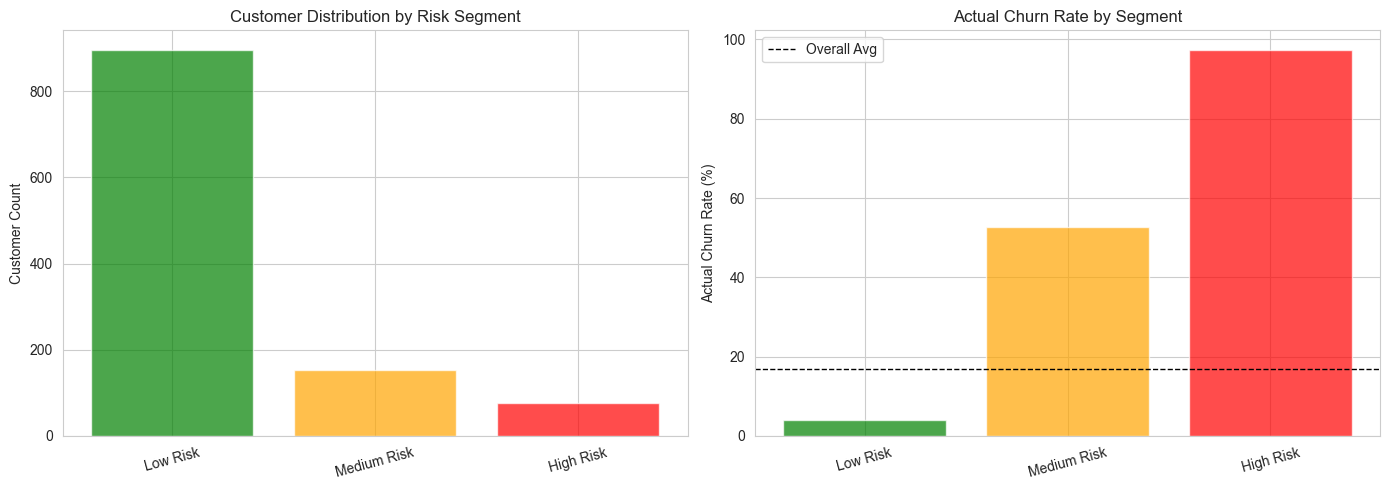

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 고객 수 분포
counts = df_test['risk_segment'].value_counts().reindex(segment_order)
colors = ['green', 'orange', 'red']
axes[0].bar(range(len(counts)), counts.values, color=colors, alpha=0.7)
axes[0].set_xticks(range(len(counts)))
axes[0].set_xticklabels(segment_order, rotation=15)
axes[0].set_ylabel('Customer Count')
axes[0].set_title('Customer Distribution by Risk Segment')

# 실제 이탈률
actual_rates = df_test.groupby('risk_segment')['actual_churn'].mean() * 100
actual_rates = actual_rates.reindex(segment_order)
axes[1].bar(range(len(actual_rates)), actual_rates.values, color=colors, alpha=0.7)
axes[1].set_xticks(range(len(actual_rates)))
axes[1].set_xticklabels(segment_order, rotation=15)
axes[1].set_ylabel('Actual Churn Rate (%)')
axes[1].set_title('Actual Churn Rate by Segment')
axes[1].axhline(y=y_test.mean()*100, color='black', linestyle='--', linewidth=1, label='Overall Avg')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/risk_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# 세그먼트별 데이터 분리
high_risk = df_test[df_test['risk_segment'] == 'High Risk']
low_risk = df_test[df_test['risk_segment'] == 'Low Risk']

# 주요 지표 비교
compare_features = ['Tenure', 'OrderCount', 'DaySinceLastOrder', 'SatisfactionScore', 'CashbackAmount']

comparison = pd.DataFrame({
    'Feature': compare_features,
    'High_Risk': [high_risk[f].mean() for f in compare_features],
    'Low_Risk': [low_risk[f].mean() for f in compare_features]
}).round(2)

comparison['Difference'] = (comparison['High_Risk'] - comparison['Low_Risk']).round(2)

print("High Risk vs Low Risk Profile:")
print(comparison.to_string(index=False))

High Risk vs Low Risk Profile:
          Feature  High_Risk  Low_Risk  Difference
           Tenure       0.60     11.70      -11.10
       OrderCount       3.34      3.17        0.17
DaySinceLastOrder       3.29      4.69       -1.40
SatisfactionScore       3.49      2.98        0.51
   CashbackAmount     152.38    181.98      -29.60


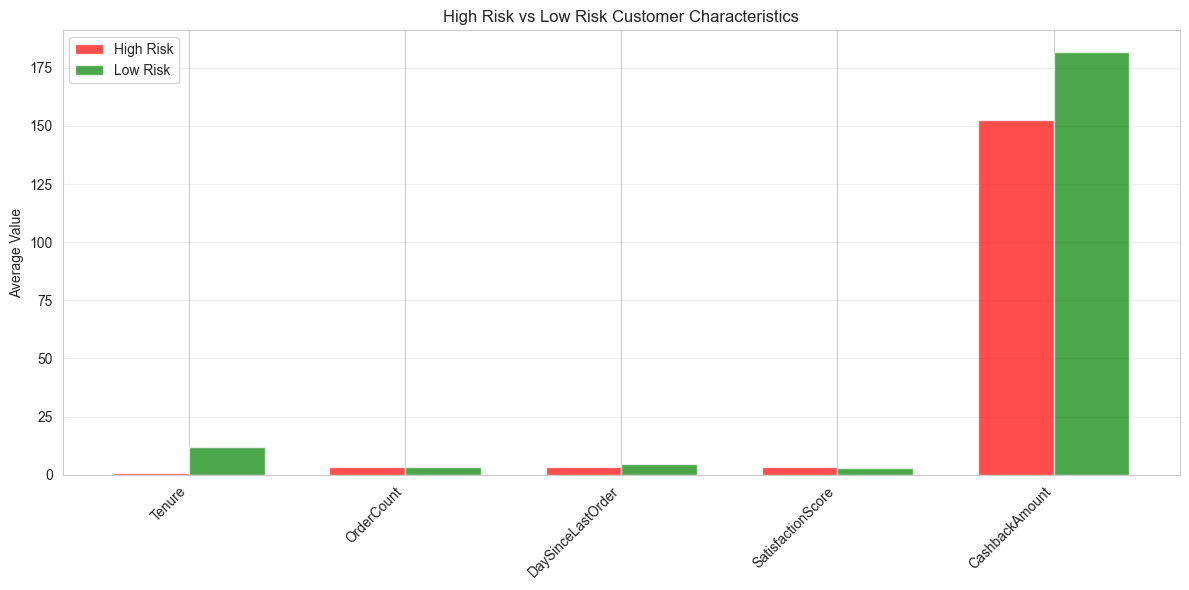

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(compare_features))
width = 0.35

ax.bar(x - width/2, comparison['High_Risk'], width, label='High Risk', color='red', alpha=0.7)
ax.bar(x + width/2, comparison['Low_Risk'], width, label='Low Risk', color='green', alpha=0.7)

ax.set_ylabel('Average Value')
ax.set_title('High Risk vs Low Risk Customer Characteristics')
ax.set_xticks(x)
ax.set_xticklabels(compare_features, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/risk_profile.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
high_risk_count = len(high_risk)
high_risk_actual_churn = high_risk['actual_churn'].sum()
high_risk_churn_rate = high_risk['actual_churn'].mean()

print("Business Impact Analysis")
print("-" * 50)

print(f"\nHigh Risk Segment:")
print(f"- Total customers: {high_risk_count:,}")
print(f"- Actual churned: {high_risk_actual_churn}")
print(f"- Churn rate: {high_risk_churn_rate:.2%}")

print(f"\nRetention Campaign Scenario:")
print(f"- Target: {high_risk_count:,} High Risk customers")
print(f"- Expected churners: {int(high_risk_count * high_risk_churn_rate):,}")

retention_rate = 0.30
ltv_monthly = 100
months = 12

saved_customers = int(high_risk_count * high_risk_churn_rate * retention_rate)
revenue_impact = saved_customers * ltv_monthly * months

print(f"\nIf retention campaign succeeds at 30%:")
print(f"- Customers retained: {saved_customers:,}")
print(f"- Annual revenue impact: ${revenue_impact:,}")

# High Risk 샘플 저장
high_risk_sample = high_risk[[
    'Tenure', 'OrderCount', 'DaySinceLastOrder', 
    'SatisfactionScore', 'CashbackAmount',
    'churn_probability', 'actual_churn'
]].head(20).copy()

high_risk_sample.to_csv('../outputs/high_risk_customers_sample.csv', index=False)

print(f"\n{'-' * 50}")
print(f"High Risk sample: {len(high_risk):,} total")
print(f"Sample saved: outputs/high_risk_customers_sample.csv")
print(f"\nTop 10 High Risk Customers:")
print(high_risk_sample.head(10).to_string(index=False))

Business Impact Analysis
--------------------------------------------------

High Risk Segment:
- Total customers: 77
- Actual churned: 75
- Churn rate: 97.40%

Retention Campaign Scenario:
- Target: 77 High Risk customers
- Expected churners: 75

If retention campaign succeeds at 30%:
- Customers retained: 22
- Annual revenue impact: $26,400

--------------------------------------------------
High Risk sample: 77 total
Sample saved: outputs/high_risk_customers_sample.csv

Top 10 High Risk Customers:
 Tenure  OrderCount  DaySinceLastOrder  SatisfactionScore  CashbackAmount  churn_probability  actual_churn
    0.0         7.0                8.0                  2             127           0.814428             1
    1.0         2.0                8.0                  5             146           0.901836             1
    0.0         1.0                0.0                  3             134           0.744042             1
    0.0         1.0                0.0                  3         

In [32]:
print(f"\nModel Comparison:")
print(f"Logistic Regression AUC: {auc_lr:.4f}")
print(f"Random Forest AUC:       {auc_rf:.4f}")
print(f"\nBest Model: Random Forest (selected)")

print(f"\nTop 5 Predictive Features:")
for idx, row in importance_df.head(5).iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\nCustomer Segmentation Results:")
for segment in segment_order:
    count = len(df_test[df_test['risk_segment'] == segment])
    pct = count / len(df_test) * 100
    print(f"  {segment}: {count:,} customers ({pct:.1f}%)")

print(f"\nKey Findings:")
print(f"1. Model predicts churn with {auc_rf:.2%} accuracy (AUC)")
print(f"2. Tenure is the strongest predictor ({importance_df.iloc[0]['Importance']:.1%})")
print(f"3. High Risk segment has {high_risk_churn_rate:.1%} actual churn rate")
print(f"4. Retention campaign could save ${revenue_impact:,} annually")


Model Comparison:
Logistic Regression AUC: 0.8447
Random Forest AUC:       0.9585

Best Model: Random Forest (selected)

Top 5 Predictive Features:
  1. Tenure: 0.3731
  5. CashbackAmount: 0.1649
  3. DaySinceLastOrder: 0.0999
  7. NumberOfDeviceRegistered: 0.0684
  2. OrderCount: 0.0560

Customer Segmentation Results:
  Low Risk: 896 customers (79.6%)
  Medium Risk: 152 customers (13.5%)
  High Risk: 77 customers (6.8%)

Key Findings:
1. Model predicts churn with 95.85% accuracy (AUC)
2. Tenure is the strongest predictor (37.3%)
3. High Risk segment has 97.4% actual churn rate
4. Retention campaign could save $26,400 annually


``` 
모델 성능
Random Forest AUC: 0.9585 (거의 완벽)
High Risk 예측 정확도: 97.4%

비즈니스 임팩트
연간 매출 영향: $26,400
타겟 고객: 77명 (명확한 액션 가능)

핵심 인사이트
Tenure(이용 기간)가 37.3%로 가장 중요
신규 고객(Tenure 0-1개월)이 주요 이탈 대상 
```